## Import Packages

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import json

tf.config.threading.set_intra_op_parallelism_threads(16) 
tf.config.threading.set_inter_op_parallelism_threads(16)

## Define Working Directory

In [2]:
path_clean_data = '/Users/rathin/Documents/Projects/mids/W207/W207_movies/data/clean_data/'

## Import Prepocessed Data 

In [3]:
# Load train, dev, test data
train_df = pd.read_csv(path_clean_data + "cf_train_ratings.csv", low_memory=False)
dev_df = pd.read_csv(path_clean_data + "cf_dev_ratings.csv", low_memory=False)
test_df = pd.read_csv(path_clean_data + "cf_test_ratings.csv", low_memory=False)

In [4]:
# drop 'Unnamed 0' column
train_df.drop('Unnamed: 0', axis=1, inplace=True)
dev_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# Inspect train_df
train_df.head()

,userId,movieId,rating
0,4,223,4.0
1,4,415,4.0
2,4,648,4.0
3,4,1097,5.0
4,4,1197,4.0


In [6]:
# Load dev and test evaluation pools
f1 = open(path_clean_data + 'dev_evaluation_pools.json',)
f2 = open(path_clean_data + 'test_evaluation_pools.json',)
dev_evaluation_pools = json.load(f1)
test_evaluation_pools = json.load(f2)

# Convert key from str to int
dev_evaluation_pools = {int(k):v for k,v in dev_evaluation_pools.items()}
test_evaluation_pools = {int(k):v for k,v in test_evaluation_pools.items()}

## Format Data for Keras

In [7]:
## Get lists of unique movie ids and user ids in the training data
unique_movie_ids = np.unique(np.concatenate((np.unique(train_df['movieId']),
                                             np.unique(dev_df['movieId']),
                                             np.unique(test_df['movieId']))))
unique_user_ids = np.unique(train_df['userId'])

## Calculate number of movies and users and print
num_movies = len(unique_movie_ids)
num_users = len(unique_user_ids)
print("Number of Movies: %i " % num_movies)
print("Number of Users: %i " % num_users)

Number of Movies: 44975 
Number of Users: 136362 


In [8]:
## Encode movies and users to be contigous  
movie2movie_encoded = {x: i for i, x in enumerate(unique_movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(unique_movie_ids)}
user2user_encoded = {x: i for i, x in enumerate(unique_user_ids)}
userencoded2user = {i: x for i, x in enumerate(unique_user_ids)}

In [9]:
## Add encoding columns to train, test and dev data
train_df["movieEncoded"] = train_df["movieId"].map(movie2movie_encoded)
train_df["userEncoded"] = train_df["userId"].map(user2user_encoded)

dev_df["movieEncoded"] = dev_df["movieId"].map(movie2movie_encoded)
dev_df["userEncoded"] = dev_df["userId"].map(user2user_encoded)

test_df["movieEncoded"] = test_df["movieId"].map(movie2movie_encoded)
test_df["userEncoded"] = test_df["userId"].map(user2user_encoded)

train_df.head()

,userId,movieId,rating,movieEncoded,userEncoded
0,4,223,4.0,220,0
1,4,415,4.0,411,0
2,4,648,4.0,640,0
3,4,1097,5.0,1075,0
4,4,1197,4.0,1172,0


## Run and Evaluate Deep Learning Models 

### Define Custom Functions

In [10]:
def sort_evaluation_pools(model, evaluation_pools, user2user_encoded, movie2movie_encoded):
    '''
    Take evaluation pool for each user and sort it based on ratings predicted by a 
    trained model in descending order of predicted ratings
    
    Parameters
    ----------
    model : A trained keras model
    evaluation_pools : A dictionary from user to the pool of movies on 
                       which to evaluate the recommender system 
    
    Returns
    -------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    '''
    
    # Instantiate output dictionary
    sorted_evaluation_pools = {}
    
    # Loop through each key-value pair in the input dictionary
    for user, movie_pool in evaluation_pools.items():
        
        # Convert to encoded is space
        user_encoded = np.array([user2user_encoded[user] for i in range(len(movie_pool))]) 
        movies_encoded =  np.array([movie2movie_encoded[movie] for movie in movie_pool])
        
        # Predict ratings based on model
        pred = model([movies_encoded, user_encoded])
        pred = pred.numpy()
        pred = pred.reshape(-1)
        
        # Sort the pool in descending order of predicted ratings
        movie_pool_array = np.array(movie_pool)
        sorted_pool_array = movie_pool_array[pred.argsort()[::-1]]
        
        # Add key-value pair of user and sorted evalualtion pool to the output dictionary
        sorted_evaluation_pools[user] = sorted_pool_array.tolist()

    return sorted_evaluation_pools

In [11]:
def calc_hit_rate_pools(sorted_evaluation_pools, test_df, top_n=10):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and the corrsponding 
    test data frame. A hit is defined as finding a test movie in the top_n of sorted 
    evalutation pool of a user
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    
    Returns
    -------
    hit_rate : A hit rate across pools
    
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]
        
        # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_id = test_movie['movieId']
            
            # If test movie is in top_movies, then add one to hits
            if test_movie_id in top_movies:
                hits += 1
                
            # Add one to total for each test movie  
            total += 1
     
    hit_rate = hits/total
    return hit_rate

In [13]:
def calc_hit_rate_pools_with_cutoff(sorted_evaluation_pools, test_df, top_n=10, rating_cutoff=0):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and a corresponding 
    test data frame. A hit is defined as finding a test movie that has a rating greater 
    than a rating_cutoff in the top_n of sorted evalutation pool of a user.
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    rating_cutoff : The threshold rating above which a test movie should be evaluated
    
    Returns
    -------
    hit_rate : A hit rate across pools
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]

         # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_rating = test_movie['rating']
            test_movie_id = test_movie['movieId']
            
             # If test movie has a rating above rating_cutoff then evaluate
            if test_movie_rating >= rating_cutoff:
                
                # If test movie is in top_movies, then add one to hits
                if test_movie_id in top_movies:
                    hits += 1
                
                # Add one to total for each test movie
                total += 1

    return hits/total

### Define Deep Learning Models

Source: https://heartbeat.fritz.ai/build-train-and-deploy-a-book-recommender-system-using-keras-tensorflow-js-b96944b936a7

In [14]:
def embedding_model(num_movies, num_users, embedding_size=15, d1_size=128):
    # Movie input network
    input_movies = layers.Input(shape=[1])

    # Define movies embedding layer
    embed_movies = layers.Embedding(num_movies + 1, embedding_size)(input_movies)
    movies_out = layers.Flatten()(embed_movies)

    # User input network
    input_users = layers.Input(shape=[1])

    # Define users embedding layer
    embed_users = layers.Embedding(num_users + 1,embedding_size)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    # Concatenenate Embeddings
    conc_layer = keras.layers.Concatenate()([movies_out, users_out])

    # Define Dense Layer                    
    x = keras.layers.Dense(d1_size, activation='relu')(conc_layer)

    # Define output Layer
    x_out = x = keras.layers.Dense(1, activation='relu')(x)

    # Define model
    model = keras.Model(inputs=[input_movies, input_users], outputs=x_out)
    
    return model

In [16]:
model_1 = embedding_model(num_movies, num_users, embedding_size=1)
opt = keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer=opt, loss='mean_squared_error')
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 1)         44976       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 1)         136363      input_4[0][0]                    
____________________________________________________________________________________________

In [17]:
model_2 = embedding_model(num_movies, num_users, embedding_size=3)
opt = keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=opt, loss='mean_squared_error')
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 3)         134928      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 3)         409089      input_6[0][0]                    
____________________________________________________________________________________________

In [19]:
model_3 = embedding_model(num_movies, num_users, embedding_size=10)
opt = keras.optimizers.Adam(learning_rate=0.001)
model_3.compile(optimizer=opt, loss='mean_squared_error')
model_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 10)        449760      input_9[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 10)        1363630     input_10[0][0]                   
____________________________________________________________________________________________

## Fit Model

In [20]:
# Fit model 1
hist_1 = model_1.fit(
    x=[train_df.movieEncoded, train_df.userEncoded],
    y=train_df.rating, 
    batch_size=128, 
    epochs=4, 
    verbose=1,
    validation_data=([dev_df.movieEncoded, dev_df.userEncoded],
                     dev_df.rating)
)

Epoch 1/4
186387/186387 [==============================] - 255s 1ms/step - loss: 0.7651 - val_loss: 0.8288
Epoch 2/4
186387/186387 [==============================] - 251s 1ms/step - loss: 0.7376 - val_loss: 0.8266
Epoch 3/4
186387/186387 [==============================] - 249s 1ms/step - loss: 0.7333 - val_loss: 0.8256
Epoch 4/4
186387/186387 [==============================] - 229s 1ms/step - loss: 0.7310 - val_loss: 0.8209


In [21]:
# save the model
model_1.save('model_embedding_depth_1')

INFO:tensorflow:Assets written to: model_embedding_depth_1/assets


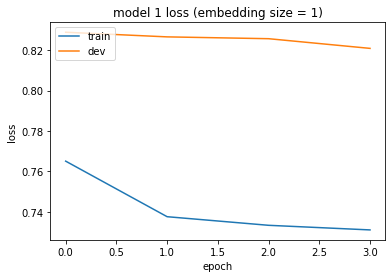

In [22]:
# Plot training and dev los vs number of epochs
plt.plot(hist_1.history["loss"])
plt.plot(hist_1.history["val_loss"])
plt.title("model 1 loss (embedding size = 1)")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

In [23]:
# Sort dev evaluation pools based on embedding model
sorted_dev_evaluation_pools = sort_evaluation_pools(model_1, dev_evaluation_pools, user2user_encoded, movie2movie_encoded)

In [25]:
# Calculate our evaluation metrics of interest
hit_rate_pools = calc_hit_rate_pools(sorted_dev_evaluation_pools, dev_df)
hit_rate_pools_with_cutoff = calc_hit_rate_pools_with_cutoff(sorted_dev_evaluation_pools, dev_df, rating_cutoff=4)
rmse = hist_1.history["val_loss"][-1]

# Print our evaluation metrics of interest
print('Model 1 (Embedding Size = 1) Metrics:')
print('HR@10 random pools: %.3f' % hit_rate_pools)
print('HR@10 random pools > 4: %.3f' % hit_rate_pools_with_cutoff)
print('Root Mean Squared Error: %.3f' % rmse)

Model 1 (Embedding Size = 1) Metrics:
HR@10 random pools: 0.487
HR@10 random pools > 4: 0.603
Root Mean Squared Error: 0.821


In [26]:
# Fit model 2
hist_2 = model_2.fit(
    x=[train_df.movieEncoded, train_df.userEncoded],
    y=train_df.rating, 
    batch_size=128, 
    epochs=4, 
    verbose=1,
    validation_data=([dev_df.movieEncoded, dev_df.userEncoded],
                     dev_df.rating)
)

Epoch 1/4
186387/186387 [==============================] - 866s 5ms/step - loss: 0.7359 - val_loss: 0.7868
Epoch 2/4
186387/186387 [==============================] - 872s 5ms/step - loss: 0.6804 - val_loss: 0.7682
Epoch 3/4
186387/186387 [==============================] - 828s 4ms/step - loss: 0.6696 - val_loss: 0.7702
Epoch 4/4
186387/186387 [==============================] - 839s 5ms/step - loss: 0.6645 - val_loss: 0.7694


In [27]:
# save the model
model_2.save('model_embedding_depth_3')

INFO:tensorflow:Assets written to: model_embedding_depth_3/assets


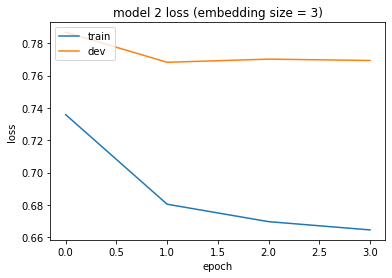

In [28]:
# Plot training and dev los vs number of epochs
plt.plot(hist_2.history["loss"])
plt.plot(hist_2.history["val_loss"])
plt.title("model 2 loss (embedding size = 3)")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

In [29]:
# Sort dev evaluation pools based on embedding model
sorted_dev_evaluation_pools = sort_evaluation_pools(model_2, dev_evaluation_pools, user2user_encoded, movie2movie_encoded)

In [30]:
# Calculate our evaluation metrics of interest
hit_rate_pools = calc_hit_rate_pools(sorted_dev_evaluation_pools, dev_df)
hit_rate_pools_with_cutoff = calc_hit_rate_pools_with_cutoff(sorted_dev_evaluation_pools, dev_df, rating_cutoff=4)
rmse = hist_2.history["val_loss"][-1]

# Print our evaluation metrics of interest
print('Model 2 (Embedding Size = 3) Metrics:')
print('HR@10 random pools: %.3f' % hit_rate_pools)
print('HR@10 random pools > 4: %.3f' % hit_rate_pools_with_cutoff)
print('Root Mean Squared Error: %.3f' % rmse)

Model 2 (Embedding Size = 3) Metrics:
HR@10 random pools: 0.571
HR@10 random pools > 4: 0.709
Root Mean Squared Error: 0.769


In [31]:
# Fit model 3
hist_3 = model_3.fit(
    x=[train_df.movieEncoded, train_df.userEncoded],
    y=train_df.rating, 
    batch_size=128, 
    epochs=4, 
    verbose=1,
    validation_data=([dev_df.movieEncoded, dev_df.userEncoded],
                     dev_df.rating)
)

Epoch 1/4
186387/186387 [==============================] - 2029s 11ms/step - loss: 0.7267 - val_loss: 0.7800
Epoch 2/4
186387/186387 [==============================] - 1604s 9ms/step - loss: 0.6560 - val_loss: 0.7495
Epoch 3/4
186387/186387 [==============================] - 1538s 8ms/step - loss: 0.6286 - val_loss: 0.7310
Epoch 4/4
186387/186387 [==============================] - 1558s 8ms/step - loss: 0.6141 - val_loss: 0.7335


In [32]:
# save the model
model_3.save('model_embedding_depth_10')

INFO:tensorflow:Assets written to: model_embedding_depth_10/assets


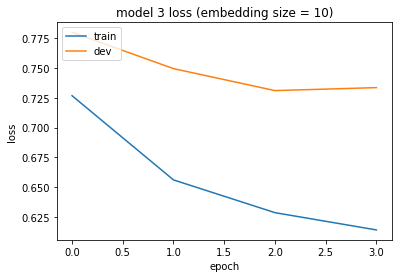

In [33]:
# Plot training and dev los vs number of epochs
plt.plot(hist_3.history["loss"])
plt.plot(hist_3.history["val_loss"])
plt.title("model 3 loss (embedding size = 10)")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.show()

In [34]:
# Sort dev evaluation pools based on embedding model
sorted_dev_evaluation_pools = sort_evaluation_pools(model_3, dev_evaluation_pools, user2user_encoded, movie2movie_encoded)

In [35]:
# Calculate our evaluation metrics of interest
hit_rate_pools = calc_hit_rate_pools(sorted_dev_evaluation_pools, dev_df)
hit_rate_pools_with_cutoff = calc_hit_rate_pools_with_cutoff(sorted_dev_evaluation_pools, dev_df, rating_cutoff=4)
rmse = hist_3.history["val_loss"][-1]

# Print our evaluation metrics of interest
print('Model 3 (Embedding Size = 10) Metrics:')
print('HR@10 random pools: %.3f' % hit_rate_pools)
print('HR@10 random pools > 4: %.3f' % hit_rate_pools_with_cutoff)
print('Root Mean Squared Error: %.3f' % rmse)

Model 3 (Embedding Size = 10) Metrics:
HR@10 random pools: 0.568
HR@10 random pools > 4: 0.715
Root Mean Squared Error: 0.734
